# Mask maps

## Prerequisites

- Understanding of basic analyses in 1D or 3D.
- Usage of `~regions` and catalogs, see the [catalog notebook](catalog.ipynb). 

## Context

There are two main categories of masks in Gammapy for different use cases.
- Fitting often requires to ignore some parts of a reduced dataset, e.g. to restrict the fit to a specific energy range or to ignore parts of the region of interest that the user does not want to model, or both. 
Gammapy's `Datasets` therefore contain a `mask_fit` sharing the same geometry as the data (i.e. `counts`).
- During data reduction, some background makers will normalize the background model template
on the data themselves. To limit contamination by real photons, one has to exclude parts of the 
field-of-view where signal is expected to be large. To do so, one needs to provide an exclusion mask. 
The latter can be provided in a different geometry as it will be reprojected by the `Makers`.

We explain in more details these two types of masks below:

### Masks for fitting: `mask_fit`

The region of interest used for the fit can defined through the dataset `mask_fit` attribute.
The `mask_fit` is a map containing boolean values where pixels used in the fit are stored as True.  

A spectral fit (1D or 3D) can be restricted to a specific energy range where e.g. the background
is well estimated or where the number of counts is large enough.
Similarly, 2D and 3D analyses usually require to work with a wider map than the region of interest so sources laying outside but reconstructed inside because of the PSF are correcly taken into account. Then the `mask_fit` have to include a margin that take into accout the PSF width. We will show an example in the boundary mask sub-section.

The `mask_fit` also can be used to exclude sources or complex regions for which we don't have good enough models. In that case the masking is an extra security, it is prefereable to include the available models even if the sources are masked and frozen.

Note that a dataset contains also a `mask_safe` attribute that is created and filled during 
data reduction. It is not to be modified directly by users. The `mask_safe` is defined only from 
the options passed to the `~gammapy.makers.SafeMaskMaker` (More details [here](https://docs.gammapy.org/dev/makers/index.html#safe-data-range-handling)).

### Exclusion masks

Background templates stored in the DL3 IRF are often not reliable enough to be used without some corrections. A set of common techniques to perform background or normalisation from the data is implemented in gammapy: reflected regions for 1D spectrum analysis, field-of-view (FoV) background or ring background for 2D and 3D analyses.

To avoid contamination of the background estimate from gamma-ray bright regions these methods require to exclude those regions from the data used for the estimation. To do so, we use exclusion masks. They are maps containing boolean values where excluded pixels are stored as False.  


## Proposed approach

Even if the use cases for exclusion masks and fit masks are different, the way to create these masks is exactly the same, so in the following we show how to work with masks in general:
- Creating masks from scratch
- Combining multiple masks
- Extending and reducing an existing mask
- Reading and writing masks


 

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from regions import CircleSkyRegion
from gammapy.maps import Map, WcsGeom, MapAxis
from gammapy.utils.regions import make_region
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import FoVBackgroundModel

## Creating a mask for fitting

One can build a `mask_fit` to restrict the energy range of pixels used to
fit a `Dataset`. The mask being a `Map` it needs to use the same geometry
(i.e. a `Geom` object) as the `Dataset` it will be applied to. 

We show here how to proceed on a `MapDataset` taken from Fermi data used in the 3FHL catalog. The dataset is already in the form of a `Datasets` object. We read it from disk.


In [64]:
filename = "$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml"
datasets = Datasets.read(filename=filename)
dataset = datasets["Fermi-LAT"]

### Create a mask in energy

We show first how to use a simple helper function `~gammapy.maps.Geom.energy_range()`.

We obtain the `Geom` that is stored on the `counts` map inside the `Dataset`
and we can directly create the `Map`.


In [104]:
mask_energy = dataset.counts.geom.energy_mask(10*u.GeV, 700*u.GeV)

# check the values of the mask at the center position for all energy bins
energy_axis = dataset.counts.geom.axes["energy"]
position = dataset.counts.geom.center_skydir
mask_energy.get_by_coord((position, energy_axis.center))

array([False,  True,  True,  True, False])

We can now set the dataset `mask_fit` attribute.  

In [86]:
dataset.mask_fit = mask_energy

If you are more familiar with the `Geom` and `Map` API, you can also create the mask manually from the coordinates of all pixels in the geometry. Here we simply show how to obtain the same behaviour as the `energy_mask` helper method.

In [106]:
coords = dataset.counts.geom.get_coord()
mask_data = (coords["energy"]>=10*u.GeV) & (coords["energy"]<700*u.GeV)
mask_energy = Map.from_geom(dataset.counts.geom, data=mask_data)

# check the values of the mask at the center position for all energy bins
mask_energy.get_by_coord((position, energy_axis.center))

array([ True,  True,  True,  True, False])

### Create the mask from a list of regions

One can build an exclusion mask from regions. We show here how to proceed.

#### Define the geometry

Masks are stored in `Map` objects. We must first define its geometry and then we can determine which pixels to exclude. Here we consider a region at the Galactic anticentre around the crab nebula.

In [43]:
position = SkyCoord(83.633083, 22.0145, unit="deg", frame="icrs")
geom = WcsGeom.create(
    skydir=position, width="5 deg", binsz=0.02, frame="galactic"
)

#### Create the list of regions

We can rely on known sources positions and properties to build a list of regions (here `~regions.SkyRegions`) enclosing most of the signal that our detector would see from these objects.

A useful function to create region objects is `~gammapy.utils.regions.make_region`. It can take strings defining regions following the "ds9" format and convert them to `regions`. 

Here we use a region enclosing the Crab nebula with 0.3 degrees. The actual region size should depend on the expected PSF of the data used. We also add another region with a different shape as en example.

In [44]:
some_region = make_region("galactic;box(185,-4,1.0,0.5, 45)")
crab_region = make_region("icrs;circle(83.633083, 22.0145, 0.3)")
regions = [some_region, crab_region]
print(regions)

[<RectangleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    (185., -4.)>, width=1.0 deg, height=0.5 deg, angle=45.0 deg)>, <CircleSkyRegion(<SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>, radius=0.3 deg)>]


Equivalently the regions can be read from a ds9 file, this time using `regions.read_ds9`. 

In [110]:
#from regions import read_ds9
#regions = read_ds9('ds9.reg')

#### Create the mask map 

We can now create the map. We use the `WcsGeom.region_mask` method putting all pixels inside the regions to False.

In [46]:
# to define the exclusion mask we take the inverse
mask_map = ~geom.region_mask(regions)

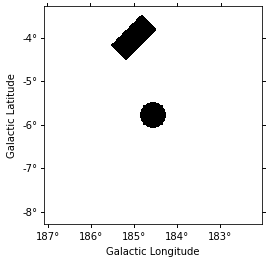

In [47]:
mask_map.plot();

### Create the mask from a catalog of sources

We can also build our list of regions from a list of catalog sources. Here we use the Fermi 4FGL catalog which we read using `~gammapy.catalog.SourceCatalog`.

In [48]:
fgl = CATALOG_REGISTRY.get_cls("4fgl")()

We now select sources that are contained in the region we are interested in.

In [49]:
inside_geom = geom.contains(fgl.positions)
idx = np.where(inside_geom)[0]

We now create the list of regions using our 0.3 degree radius a priori value. If the sources were extended, one would have to adapt the sizes to account for the larger size.

In [50]:
exclusion_radius = Angle("0.3 deg")
regions = [CircleSkyRegion(fgl[i].position, exclusion_radius) for i in idx]

Now we can build the mask map the same way as above.

In [51]:
mask_map_catalog = ~geom.region_mask(regions)

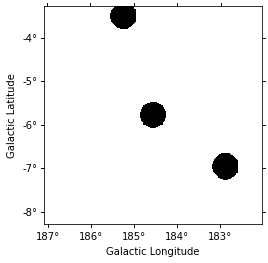

In [52]:
mask_map_catalog.plot();

### Create the mask from statistically significant pixels in a dataset

Here we want to determine an exclusion from the data directly. We will estimate the significance of the data using the `ExcessMapEstimator`, and exclude all pixels above a given threshold.

Here we use the `MapDataset` taken from the Fermi data used above.

We apply a significance estimation. We integrate the counts using a correlation radius of 0.4 degree and apply regular significance estimate. 

In [54]:
estimator = ExcessMapEstimator("0.4 deg", selection_optional=[])
result = estimator.run(dataset)

HDU 'MASK_FIT' not found


Finally, we create the mask map by applying a threshold of 5 sigma to remove pixels.

In [55]:
significance_mask = result["sqrt_ts"] < 5.0

Because the `ExcessMapEstimator` returns NaN for masked pixels, we need to put the NaN values to `True` to avoid incorrectly excluding them. 

In [56]:
invalid_pixels = np.isnan(result["sqrt_ts"].data)
significance_mask.data[invalid_pixels] = True

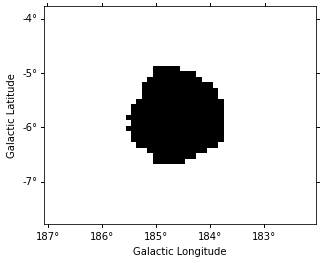

In [57]:
significance_mask.plot();

This method frequently yields isolated pixels or weakly significant features if one places the threshold too low. 

To overcome this issue, one can use `~skimage.filters.apply_hysteresis_threshold` . This filter allows to define two thresholds and mask only the pixels between the low and high thresholds if they are not continuously connected to a pixel above the high threshold. This allows to better preserve the structure of the excesses. 

Note that scikit-image is not a required dependency of gammapy, you might need to install it.


## Masks operations

If two masks share the same geometry it is easy to combine them with `Map` arithmetics.

OR condition is represented by `|` operator :

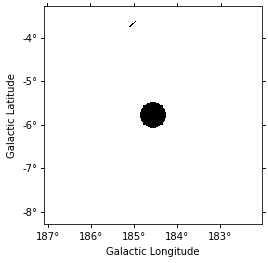

In [58]:
mask = mask_map | mask_map_catalog
mask.plot();


AND condition is represented by `&` or `*` operators :

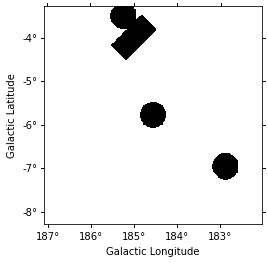

In [59]:
mask_map &= mask_map_catalog
mask_map.plot();

The NOT operator is represented by `~` symbol:

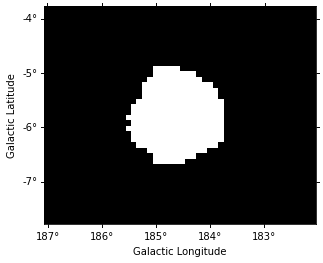

In [60]:
significance_mask_inv = ~significance_mask
significance_mask_inv.plot();

## Mask modifications

### Mask dilation and erosion

One can reduce or extend a mask using `binary_erode` and  `binary_dilate` methods, respectively.

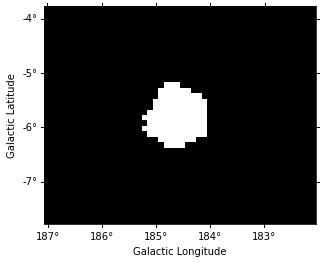

In [61]:
mask = significance_mask_inv.binary_erode(width=0.2 * u.deg, kernel="disk")
mask.plot();

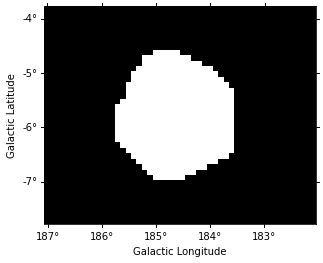

In [62]:
mask = significance_mask_inv.binary_dilate(width=0.2 * u.deg)
mask.plot();

### Boundary mask

In the following example we use the Fermi dataset previously loaded and add its `mask_fit` taking into account a margin based on the psf width. The margin width is determined using the `containment_radius` method of the psf object and the mask is created using the `boundary_mask` method available on the geometry object.

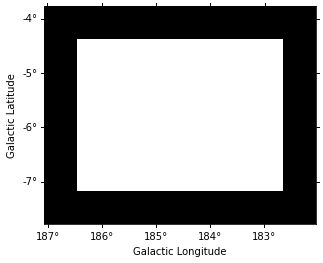

In [63]:
#get PSF 95% containment radius
energy_true = dataset.exposure.geom.axes[0].center
psf_r95 = dataset.psf.containment_radius(fraction=0.95, energy_true=energy_true)
#create mask_fit with margin based on PSF
mask_fit = dataset.counts.geom.boundary_mask(psf_r95.max())
dataset.mask_fit = mask_fit
dataset.mask_fit.sum_over_axes().plot();

## Reading and writing masks

`gammapy.maps` can directly read/write maps with boolean content as follows:

In [ ]:
# To save masks to disk
mask_map.write("exclusion_mask.fits", overwrite="True")

In [ ]:
# To read maps from disk
mask_map = Map.read("exclusion_mask.fits")